In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_auc_score
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows', None)  # 设置显示最大
data = pd.read_csv("D:/propycharm2023/mq5/KDATA_type.csv")
data = data.drop(['Unnamed: 0', '时间','volume','订单规定价格', '订单ID', 'profit', '类型',
                  'fractals_up_arrow_1D_bin', 'fractals_up_arrow', 'fractals_up_arrow_15M_bin',
          'fractals_up_arrow_30M_bin', 'fractals_up_arrow_1H_bin',
         'fractals_down_arrow_1D_bin', 'fractals_down_arrow', 'fractals_down_arrow_15M_bin',
          'fractals_down_arrow_30M_bin', 'fractals_down_arrow_1H_bin'], axis=1, inplace=False)
data = data.dropna(axis=0)
print(data.shape)
data.describe()

(105102, 6486)


open_price           high            low          close  \
count  105102.000000  105102.000000  105102.000000  105102.000000   
mean     1859.343594    1859.938331    1858.743112    1859.342744   
std       101.817874     101.839906     101.795103     101.819417   
min      1615.840000    1617.120000    1614.810000    1615.830000   
25%      1788.540000    1789.010000    1788.032500    1788.542500   
50%      1874.030000    1874.620000    1873.330000    1874.035000   
75%      1936.807500    1937.310000    1936.300000    1936.800000   
max      2069.370000    2070.300000    2062.950000    2069.360000   

        open_change1   open_change2   open_change3   open_change4  \
count  105102.000000  105102.000000  105102.000000  105102.000000   
mean       -0.000042      -0.000028       0.000008       0.000017   
std         0.051470       0.051310       0.051333       0.050134   
min        -0.991800      -0.991800      -0.991800      -0.991800   
25%        -0.022500      -0.022500      -0.022400      -0.022400   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.022200       0.022200       0.022200       0.022200   
max         1.695100       1.695100       1.695100       1.695100   

       open_change5   open_change6   open_change7   open_change8  \
count  1.051020e+05  105102.000000  105102.000000  105102.000000   
mean   2.778254e-07       0.000009       0.000008       0.000030   
std    5.028624e-02       0.050159       0.050049       0.050108   
min   -9.918000e-01      -0.991800      -0.991800      -0.991800   
25%   -2.240000e-02      -0.022400      -0.022400      -0.022400   
50%    0.000000e+00       0.000000       0.000000       0.000000   
75%    2.217500e-02       0.022100       0.022100       0.022200   
max    1.695100e+00       1.695100       1.695100       1.695100   

        open_change9  open_change10  open_change11  open_change12  \
count  105102.000000  105102.000000  105102.000000  105102.000000   
mean        0.000040       0.000021       0.000014      -0.000003   
std         0.050205       0.050224       0.050365       0.050469   
min        -0.991800      -0.991800      -0.991800      -0.991800   
25%        -0.022400      -0.022400      -0.022400      -0.022500   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.022200       0.022200       0.022200       0.022200   
max         1.695100       1.695100       1.695100       1.695100   

       open_change13  open_change14  open_change15  open_change16  \
count  105102.000000  105102.000000  105102.000000  105102.000000   
mean        0.000007       0.000014       0.000004       0.000009   
std         0.050525       0.050636       0.050794       0.051031   
min        -0.991800      -0.991800      -0.991800      -0.991800   
25%        -0.022500      -0.022600      -0.022600      -0.022600   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.022200       0.022300       0.022300       0.022400   
max         1.695100       1.695100       1.695100       1.695100   

       open_change17  open_change18  open_change19  open_change20  \
count  105102.000000  105102.000000  105102.000000  105102.000000   
mean       -0.000012       0.000024       0.000023       0.000019   
std         0.051282       0.052285       0.052355       0.052689   
min        -0.991800      -0.991800      -0.991800      -0.991800   
25%        -0.022700      -0.022700      -0.022700      -0.022800   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.022400       0.022400       0.022400       0.022500   
max         1.695100       1.695100       1.695100       1.695100   

       open_current_change2  open_current_change3  open_current_change4  \
count         105102.000000         105102.000000         105102.000000   
mean              -0.000071             -0.000064             -0.000047   
std                0.072043              0.087985             

In [3]:
#注意 需要保持数据类型一致int
col = ['atr_5_10_type', 'macd_type', 'sma_5_10_type', 'ema_5_10_type', 'smma_5_10_type', 'lwma_5_10_type',
       'rsi_5_14_type', 'sar_type', 'adx_type', 'cci_type', 'stoch_type', 'boll_type', 'ac_type', 'ad_type',
       'adxWilder_type',
       'alligator_type', 'ama_type', 'ao_type', 'bearsPower_type', 'bullsPower_type', 'chaikin_type', 'dema_type',
       'deMarker_type', 'envelopes_type', 'force_type', 'fractals_type', 'frAMA_type', 'gator_type',
       'ichimoku_type',
       'bwmfi_type', 'momentum_type', 'mfi_type', 'osMA_type', 'obv_type', 'rvi_type', 'stdDev_type', 'tema_type',
       'triX_type', 'wpr_type', 'vidya_type',
       'ac_color', 'ao_color', 'gator_up_color', 'gator_downs_color', 'bwmfi_color', 
       
        'atr_5_10_type_15M_bin', 'macd_type_15M_bin', 'sma_5_10_type_15M_bin', 'ema_5_10_type_15M_bin', 
       'smma_5_10_type_15M_bin', 'lwma_5_10_type_15M_bin',
       'rsi_5_14_type_15M_bin', 'sar_type_15M_bin', 'adx_type_15M_bin', 'cci_type_15M_bin', 'stoch_type_15M_bin',
       'boll_type_15M_bin', 'ac_type_15M_bin', 'ad_type_15M_bin',
       'adxWilder_type_15M_bin',
       'alligator_type_15M_bin', 'ama_type_15M_bin', 'ao_type_15M_bin', 'bearsPower_type_15M_bin', 'bullsPower_type_15M_bin', 
       'chaikin_type_15M_bin', 'dema_type_15M_bin',
       'deMarker_type_15M_bin', 'envelopes_type_15M_bin', 'force_type_15M_bin', 'fractals_type_15M_bin', 'frAMA_type_15M_bin', 
       'gator_type_15M_bin',
       'ichimoku_type_15M_bin',
       'bwmfi_type_15M_bin', 'momentum_type_15M_bin', 'mfi_type_15M_bin', 'osMA_type_15M_bin', 'obv_type_15M_bin', 
       'rvi_type_15M_bin', 'stdDev_type_15M_bin', 'tema_type_15M_bin',
       'triX_type_15M_bin', 'wpr_type_15M_bin', 'vidya_type_15M_bin',
       'ac_color_15M_bin', 'ao_color_15M_bin', 'gator_up_color_15M_bin', 'gator_downs_color_15M_bin', 'bwmfi_color_15M_bin',
       
      'atr_5_10_type_30M_bin', 'macd_type_30M_bin', 'sma_5_10_type_30M_bin', 'ema_5_10_type_30M_bin', 
       'smma_5_10_type_30M_bin', 'lwma_5_10_type_30M_bin',
       'rsi_5_14_type_30M_bin', 'sar_type_30M_bin', 'adx_type_30M_bin', 'cci_type_30M_bin', 'stoch_type_30M_bin', 
       'boll_type_30M_bin', 'ac_type_30M_bin', 'ad_type_30M_bin',
       'adxWilder_type_30M_bin',
       'alligator_type_30M_bin', 'ama_type_30M_bin', 'ao_type_30M_bin', 'bearsPower_type_30M_bin', 'bullsPower_type_30M_bin', 
       'chaikin_type_30M_bin', 'dema_type_30M_bin',
       'deMarker_type_30M_bin', 'envelopes_type_30M_bin', 'force_type_30M_bin', 'fractals_type_30M_bin', 'frAMA_type_30M_bin', 
       'gator_type_30M_bin',
       'ichimoku_type_30M_bin',
       'bwmfi_type_30M_bin', 'momentum_type_30M_bin', 'mfi_type_30M_bin', 'osMA_type_30M_bin', 'obv_type_30M_bin', 
       'rvi_type_30M_bin', 'stdDev_type_30M_bin', 'tema_type_30M_bin',
       'triX_type_30M_bin', 'wpr_type_30M_bin', 'vidya_type_30M_bin',
       'ac_color_30M_bin', 'ao_color_30M_bin', 'gator_up_color_30M_bin', 'gator_downs_color_30M_bin', 'bwmfi_color_30M_bin',
       
      'atr_5_10_type_1H_bin', 'macd_type_1H_bin', 'sma_5_10_type_1H_bin', 'ema_5_10_type_1H_bin', 
       'smma_5_10_type_1H_bin', 'lwma_5_10_type_1H_bin',
       'rsi_5_14_type_1H_bin', 'sar_type_1H_bin', 'adx_type_1H_bin', 'cci_type_1H_bin', 'stoch_type_1H_bin', 
       'boll_type_1H_bin', 'ac_type_1H_bin', 'ad_type_1H_bin',
       'adxWilder_type_1H_bin',
       'alligator_type_1H_bin', 'ama_type_1H_bin', 'ao_type_1H_bin', 'bearsPower_type_1H_bin', 'bullsPower_type_1H_bin', 
       'chaikin_type_1H_bin', 'dema_type_1H_bin',
       'deMarker_type_1H_bin', 'envelopes_type_1H_bin', 'force_type_1H_bin', 'fractals_type_1H_bin', 'frAMA_type_1H_bin', 
       'gator_type_1H_bin',
       'ichimoku_type_1H_bin',
       'bwmfi_type_1H_bin', 'momentum_type_1H_bin', 'mfi_type_1H_bin', 'osMA_type_1H_bin', 'obv_type_1H_bin', 
       'rvi_type_1H_bin', 'stdDev_type_1H_bin', 'tema_type_1H_bin',
       'triX_type_1H_bin', 'wpr_type_1H_bin', 'vidya_type_1H_bin',
       'ac_color_1H_bin', 'ao_color_1H_bin', 'gator_up_color_1H_bin', 'gator_downs_color_1H_bin', 'bwmfi_color_1H_bin',
      
       'atr_5_10_type_1D_bin', 'macd_type_1D_bin', 'sma_5_10_type_1D_bin', 'ema_5_10_type_1D_bin', 
       'smma_5_10_type_1D_bin', 'lwma_5_10_type_1D_bin',
       'rsi_5_14_type_1D_bin', 'sar_type_1D_bin', 'adx_type_1D_bin', 'cci_type_1D_bin', 'stoch_type_1D_bin', 
       'boll_type_1D_bin', 'ac_type_1D_bin', 'ad_type_1D_bin',
       'adxWilder_type_1D_bin',
       'alligator_type_1D_bin', 'ama_type_1D_bin', 'ao_type_1D_bin', 'bearsPower_type_1D_bin', 'bullsPower_type_1D_bin', 
       'chaikin_type_1D_bin', 'dema_type_1D_bin',
       'deMarker_type_1D_bin', 'envelopes_type_1D_bin', 'force_type_1D_bin', 'fractals_type_1D_bin', 'frAMA_type_1D_bin', 
       'gator_type_1D_bin',
       'ichimoku_type_1D_bin',
       'bwmfi_type_1D_bin', 'momentum_type_1D_bin', 'mfi_type_1D_bin', 'osMA_type_1D_bin', 'obv_type_1D_bin', 
       'rvi_type_1D_bin', 'stdDev_type_1D_bin', 'tema_type_1D_bin',
       'triX_type_1D_bin', 'wpr_type_1D_bin', 'vidya_type_1D_bin',
       'ac_color_1D_bin', 'ao_color_1D_bin', 'gator_up_color_1D_bin', 'gator_downs_color_1D_bin', 'bwmfi_color_1D_bin']

data[col] = (data[col].astype(str))

replace_dict = {'0':'z', '1': 'A', '2': 'B', '3': 'C', '4': 'D', 
                '5': 'E', '6': 'F', '7': 'G', '8': 'H', '9': 'I', 
                '10': 'J', '11':'K', '12':'L', '13':'M', '14':'N'}

data[col] = data[col].replace(replace_dict)



In [4]:
#特征和标签
X = data.iloc[:,:-1]
Y = data.iloc[:, -1]
# #标准化StandardScaler()
scaler = StandardScaler()

# 对指定列进行标准化
X_scaled = scaler.fit_transform((X[X.columns.difference(col)].astype(float)))

# 将标准化后的数据转换为 DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns.difference(col))
# 合并标准化后的数据和其他列
X_merged = pd.concat([X_scaled_df, X[col]], axis=1)

X_train,X_test,Y_train,Y_test = train_test_split(X_merged,Y,test_size=0.1,random_state = 3)

In [5]:
del data  # 删除列表,释放内存
del X_scaled
del X_scaled_df
del X_merged
del X
del Y

In [6]:
Y_train[:-10000].describe()

count    14591.000000
mean         0.307381
std          0.461425
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: type, dtype: float64

In [20]:
# 
train_pool = Pool(X_train[:-10000],label = Y_train[:-10000],cat_features = col)
eval_pool = Pool(X_train[-10000:],label = Y_train[-10000:],cat_features = col)
test_pool = Pool(X_test,cat_features = col)
# 'one_hot_max_size': 4, # 对唯一值数量<one_hot_max_size的类别型特征使用one-hot编码
# 自定义评估指标函数：AUC
# def precision_eval(y_true, y_pred):
#     return precision_score(y_true, y_pred)
#3.33
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'depth': 8,
    'early_stopping_rounds': 20,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.63],
    'eval_metric':'Precision'
    
}
model = CatBoostClassifier(**params)

In [21]:
model.fit(train_pool,eval_set=eval_pool)

0:	learn: 0.6563878	test: 0.6583692	best: 0.6583692 (0)	total: 1.48s	remaining: 24m 40s
1:	learn: 0.7067389	test: 0.7124310	best: 0.7124310 (1)	total: 2.97s	remaining: 24m 42s
2:	learn: 0.7225256	test: 0.7276880	best: 0.7276880 (2)	total: 4.42s	remaining: 24m 29s
3:	learn: 0.7272343	test: 0.7319067	best: 0.7319067 (3)	total: 5.84s	remaining: 24m 14s
4:	learn: 0.7315132	test: 0.7345228	best: 0.7345228 (4)	total: 7.23s	remaining: 23m 59s
5:	learn: 0.7336278	test: 0.7363090	best: 0.7363090 (5)	total: 9.04s	remaining: 24m 58s
6:	learn: 0.7373667	test: 0.7409549	best: 0.7409549 (6)	total: 10.5s	remaining: 24m 45s
7:	learn: 0.7386315	test: 0.7421374	best: 0.7421374 (7)	total: 11.9s	remaining: 24m 36s
8:	learn: 0.7390241	test: 0.7420085	best: 0.7421374 (7)	total: 13.4s	remaining: 24m 31s
9:	learn: 0.7383789	test: 0.7398308	best: 0.7421374 (7)	total: 14.8s	remaining: 24m 27s
10:	learn: 0.7366093	test: 0.7384954	best: 0.7421374 (7)	total: 16.7s	remaining: 25m
11:	learn: 0.7355698	test: 0.737093

92:	learn: 0.7790424	test: 0.7801252	best: 0.7801252 (92)	total: 2m 21s	remaining: 23m 2s
93:	learn: 0.7793455	test: 0.7805077	best: 0.7805077 (93)	total: 2m 23s	remaining: 22m 59s
94:	learn: 0.7797785	test: 0.7805702	best: 0.7805702 (94)	total: 2m 24s	remaining: 22m 56s
95:	learn: 0.7802616	test: 0.7813211	best: 0.7813211 (95)	total: 2m 26s	remaining: 22m 57s
96:	learn: 0.7808233	test: 0.7826872	best: 0.7826872 (96)	total: 2m 27s	remaining: 22m 54s
97:	learn: 0.7811520	test: 0.7828756	best: 0.7828756 (97)	total: 2m 29s	remaining: 22m 52s
98:	learn: 0.7813848	test: 0.7836250	best: 0.7836250 (98)	total: 2m 30s	remaining: 22m 50s
99:	learn: 0.7820050	test: 0.7839501	best: 0.7839501 (99)	total: 2m 32s	remaining: 22m 48s
100:	learn: 0.7823218	test: 0.7840183	best: 0.7840183 (100)	total: 2m 33s	remaining: 22m 50s
101:	learn: 0.7835693	test: 0.7850172	best: 0.7850172 (101)	total: 2m 35s	remaining: 22m 48s
102:	learn: 0.7841091	test: 0.7857817	best: 0.7857817 (102)	total: 2m 36s	remaining: 22

181:	learn: 0.8155451	test: 0.8188100	best: 0.8188100 (181)	total: 4m 37s	remaining: 20m 45s
182:	learn: 0.8155408	test: 0.8186915	best: 0.8188100 (181)	total: 4m 38s	remaining: 20m 43s
183:	learn: 0.8164265	test: 0.8195606	best: 0.8195606 (183)	total: 4m 39s	remaining: 20m 41s
184:	learn: 0.8169106	test: 0.8207920	best: 0.8207920 (184)	total: 4m 41s	remaining: 20m 39s
185:	learn: 0.8171512	test: 0.8210849	best: 0.8210849 (185)	total: 4m 43s	remaining: 20m 39s
186:	learn: 0.8174612	test: 0.8213593	best: 0.8213593 (186)	total: 4m 44s	remaining: 20m 37s
187:	learn: 0.8177913	test: 0.8213096	best: 0.8213593 (186)	total: 4m 46s	remaining: 20m 35s
188:	learn: 0.8181382	test: 0.8218095	best: 0.8218095 (188)	total: 4m 47s	remaining: 20m 33s
189:	learn: 0.8184547	test: 0.8220957	best: 0.8220957 (189)	total: 4m 49s	remaining: 20m 32s
190:	learn: 0.8188877	test: 0.8225083	best: 0.8225083 (190)	total: 4m 51s	remaining: 20m 33s
191:	learn: 0.8192927	test: 0.8226265	best: 0.8226265 (191)	total: 4m 

270:	learn: 0.8403354	test: 0.8449756	best: 0.8450480 (269)	total: 6m 56s	remaining: 18m 39s
271:	learn: 0.8406190	test: 0.8454103	best: 0.8454103 (271)	total: 6m 57s	remaining: 18m 37s
272:	learn: 0.8413676	test: 0.8459180	best: 0.8459180 (272)	total: 6m 58s	remaining: 18m 35s
273:	learn: 0.8412905	test: 0.8460346	best: 0.8460346 (273)	total: 7m	remaining: 18m 33s
274:	learn: 0.8419657	test: 0.8465428	best: 0.8465428 (274)	total: 7m 1s	remaining: 18m 32s
275:	learn: 0.8422043	test: 0.8464702	best: 0.8465428 (274)	total: 7m 3s	remaining: 18m 31s
276:	learn: 0.8424496	test: 0.8469790	best: 0.8469790 (276)	total: 7m 5s	remaining: 18m 30s
277:	learn: 0.8429963	test: 0.8475612	best: 0.8475612 (277)	total: 7m 6s	remaining: 18m 28s
278:	learn: 0.8431153	test: 0.8478091	best: 0.8478091 (278)	total: 7m 8s	remaining: 18m 26s
279:	learn: 0.8434215	test: 0.8484222	best: 0.8484222 (279)	total: 7m 9s	remaining: 18m 24s
280:	learn: 0.8435709	test: 0.8484361	best: 0.8484361 (280)	total: 7m 11s	remain

359:	learn: 0.8599743	test: 0.8632247	best: 0.8634510 (357)	total: 9m 13s	remaining: 16m 24s
360:	learn: 0.8600181	test: 0.8636774	best: 0.8636774 (360)	total: 9m 15s	remaining: 16m 23s
361:	learn: 0.8601204	test: 0.8634113	best: 0.8636774 (360)	total: 9m 17s	remaining: 16m 21s
362:	learn: 0.8603580	test: 0.8633001	best: 0.8636774 (360)	total: 9m 18s	remaining: 16m 20s
363:	learn: 0.8605380	test: 0.8633399	best: 0.8636774 (360)	total: 9m 19s	remaining: 16m 18s
364:	learn: 0.8607702	test: 0.8639075	best: 0.8639075 (364)	total: 9m 21s	remaining: 16m 16s
365:	learn: 0.8609455	test: 0.8639471	best: 0.8639471 (365)	total: 9m 23s	remaining: 16m 15s
366:	learn: 0.8611537	test: 0.8638717	best: 0.8639471 (365)	total: 9m 24s	remaining: 16m 14s
367:	learn: 0.8613325	test: 0.8640226	best: 0.8640226 (367)	total: 9m 26s	remaining: 16m 12s
368:	learn: 0.8614619	test: 0.8642490	best: 0.8642490 (368)	total: 9m 27s	remaining: 16m 10s
369:	learn: 0.8620043	test: 0.8647778	best: 0.8647778 (369)	total: 9m 

447:	learn: 0.8765721	test: 0.8770180	best: 0.8771316 (446)	total: 11m 29s	remaining: 14m 10s
448:	learn: 0.8766269	test: 0.8770955	best: 0.8771316 (446)	total: 11m 31s	remaining: 14m 8s
449:	learn: 0.8766774	test: 0.8770542	best: 0.8771316 (446)	total: 11m 32s	remaining: 14m 6s
450:	learn: 0.8767741	test: 0.8770490	best: 0.8771316 (446)	total: 11m 34s	remaining: 14m 5s
451:	learn: 0.8771985	test: 0.8777047	best: 0.8777047 (451)	total: 11m 36s	remaining: 14m 3s
452:	learn: 0.8772405	test: 0.8777103	best: 0.8777103 (452)	total: 11m 37s	remaining: 14m 2s
453:	learn: 0.8773039	test: 0.8778655	best: 0.8778655 (453)	total: 11m 39s	remaining: 14m
454:	learn: 0.8774949	test: 0.8778238	best: 0.8778655 (453)	total: 11m 40s	remaining: 13m 59s
455:	learn: 0.8776464	test: 0.8779014	best: 0.8779014 (455)	total: 11m 42s	remaining: 13m 57s
456:	learn: 0.8778229	test: 0.8777103	best: 0.8779014 (455)	total: 11m 43s	remaining: 13m 56s
457:	learn: 0.8779375	test: 0.8784447	best: 0.8784447 (457)	total: 11

535:	learn: 0.8880083	test: 0.8882400	best: 0.8882400 (535)	total: 13m 46s	remaining: 11m 55s
536:	learn: 0.8880501	test: 0.8884322	best: 0.8884322 (536)	total: 13m 47s	remaining: 11m 53s
537:	learn: 0.8881336	test: 0.8885117	best: 0.8885117 (537)	total: 13m 49s	remaining: 11m 52s
538:	learn: 0.8881296	test: 0.8885117	best: 0.8885117 (537)	total: 13m 50s	remaining: 11m 50s
539:	learn: 0.8881943	test: 0.8885912	best: 0.8885912 (539)	total: 13m 52s	remaining: 11m 48s
540:	learn: 0.8885117	test: 0.8889094	best: 0.8889094 (540)	total: 13m 54s	remaining: 11m 47s
541:	learn: 0.8885362	test: 0.8889559	best: 0.8889559 (541)	total: 13m 55s	remaining: 11m 46s
542:	learn: 0.8887656	test: 0.8891482	best: 0.8891482 (542)	total: 13m 56s	remaining: 11m 44s
543:	learn: 0.8888902	test: 0.8889094	best: 0.8891482 (542)	total: 13m 58s	remaining: 11m 42s
544:	learn: 0.8888926	test: 0.8892278	best: 0.8892278 (544)	total: 13m 59s	remaining: 11m 41s
545:	learn: 0.8890574	test: 0.8893074	best: 0.8893074 (545)	

623:	learn: 0.8985078	test: 0.8969885	best: 0.8969885 (623)	total: 16m	remaining: 9m 39s
624:	learn: 0.8987806	test: 0.8970696	best: 0.8970696 (624)	total: 16m 2s	remaining: 9m 37s
625:	learn: 0.8988313	test: 0.8972318	best: 0.8972318 (625)	total: 16m 4s	remaining: 9m 36s
626:	learn: 0.8989533	test: 0.8973438	best: 0.8973438 (626)	total: 16m 5s	remaining: 9m 34s
627:	learn: 0.8989751	test: 0.8975871	best: 0.8975871 (627)	total: 16m 7s	remaining: 9m 32s
628:	learn: 0.8991975	test: 0.8978306	best: 0.8978306 (628)	total: 16m 8s	remaining: 9m 31s
629:	learn: 0.8992169	test: 0.8980742	best: 0.8980742 (629)	total: 16m 10s	remaining: 9m 29s
630:	learn: 0.8994975	test: 0.8983686	best: 0.8983686 (630)	total: 16m 12s	remaining: 9m 28s
631:	learn: 0.8996233	test: 0.8986125	best: 0.8986125 (631)	total: 16m 13s	remaining: 9m 26s
632:	learn: 0.8996001	test: 0.8985312	best: 0.8986125 (631)	total: 16m 14s	remaining: 9m 25s
633:	learn: 0.8996703	test: 0.8985006	best: 0.8986125 (631)	total: 16m 16s	rema

712:	learn: 0.9083315	test: 0.9079557	best: 0.9079557 (712)	total: 18m 17s	remaining: 7m 21s
713:	learn: 0.9085713	test: 0.9077898	best: 0.9079557 (712)	total: 18m 19s	remaining: 7m 20s
714:	learn: 0.9086140	test: 0.9077898	best: 0.9079557 (712)	total: 18m 20s	remaining: 7m 18s
715:	learn: 0.9086764	test: 0.9081218	best: 0.9081218 (715)	total: 18m 22s	remaining: 7m 17s
716:	learn: 0.9088341	test: 0.9082048	best: 0.9082048 (716)	total: 18m 23s	remaining: 7m 15s
717:	learn: 0.9087947	test: 0.9083709	best: 0.9083709 (717)	total: 18m 25s	remaining: 7m 14s
718:	learn: 0.9089523	test: 0.9083709	best: 0.9083709 (717)	total: 18m 26s	remaining: 7m 12s
719:	learn: 0.9089688	test: 0.9083158	best: 0.9083709 (717)	total: 18m 28s	remaining: 7m 11s
720:	learn: 0.9089523	test: 0.9083436	best: 0.9083709 (717)	total: 18m 30s	remaining: 7m 9s
721:	learn: 0.9091659	test: 0.9087589	best: 0.9087589 (721)	total: 18m 31s	remaining: 7m 8s
722:	learn: 0.9092218	test: 0.9088144	best: 0.9088144 (722)	total: 18m 3

801:	learn: 0.9157320	test: 0.9156939	best: 0.9156939 (801)	total: 20m 34s	remaining: 5m 4s
802:	learn: 0.9158050	test: 0.9157781	best: 0.9157781 (802)	total: 20m 35s	remaining: 5m 3s
803:	learn: 0.9159802	test: 0.9161993	best: 0.9161993 (803)	total: 20m 37s	remaining: 5m 1s
804:	learn: 0.9160840	test: 0.9161993	best: 0.9161993 (803)	total: 20m 38s	remaining: 5m
805:	learn: 0.9162240	test: 0.9164522	best: 0.9164522 (805)	total: 20m 40s	remaining: 4m 58s
806:	learn: 0.9163440	test: 0.9165365	best: 0.9165365 (806)	total: 20m 41s	remaining: 4m 56s
807:	learn: 0.9165011	test: 0.9167052	best: 0.9167052 (807)	total: 20m 43s	remaining: 4m 55s
808:	learn: 0.9165271	test: 0.9167896	best: 0.9167896 (808)	total: 20m 44s	remaining: 4m 53s
809:	learn: 0.9165002	test: 0.9166209	best: 0.9167896 (808)	total: 20m 46s	remaining: 4m 52s
810:	learn: 0.9165902	test: 0.9167052	best: 0.9167896 (808)	total: 20m 48s	remaining: 4m 50s
811:	learn: 0.9166111	test: 0.9166797	best: 0.9167896 (808)	total: 20m 49s	re

890:	learn: 0.9214698	test: 0.9213083	best: 0.9213083 (890)	total: 22m 50s	remaining: 2m 47s
891:	learn: 0.9215707	test: 0.9215640	best: 0.9215640 (891)	total: 22m 51s	remaining: 2m 46s
892:	learn: 0.9215909	test: 0.9216492	best: 0.9216492 (892)	total: 22m 53s	remaining: 2m 44s
893:	learn: 0.9216269	test: 0.9213935	best: 0.9216492 (892)	total: 22m 54s	remaining: 2m 42s
894:	learn: 0.9216039	test: 0.9213935	best: 0.9216492 (892)	total: 22m 56s	remaining: 2m 41s
895:	learn: 0.9218159	test: 0.9215881	best: 0.9216492 (892)	total: 22m 57s	remaining: 2m 39s
896:	learn: 0.9217812	test: 0.9215029	best: 0.9216492 (892)	total: 22m 59s	remaining: 2m 38s
897:	learn: 0.9220309	test: 0.9218439	best: 0.9218439 (897)	total: 23m	remaining: 2m 36s
898:	learn: 0.9220338	test: 0.9219904	best: 0.9219904 (898)	total: 23m 2s	remaining: 2m 35s
899:	learn: 0.9220742	test: 0.9220757	best: 0.9220757 (899)	total: 23m 3s	remaining: 2m 33s
900:	learn: 0.9220252	test: 0.9220757	best: 0.9220757 (899)	total: 23m 5s	re

979:	learn: 0.9256619	test: 0.9261268	best: 0.9261268 (978)	total: 25m 9s	remaining: 30.8s
980:	learn: 0.9256416	test: 0.9262357	best: 0.9262357 (980)	total: 25m 11s	remaining: 29.3s
981:	learn: 0.9257277	test: 0.9261725	best: 0.9262357 (980)	total: 25m 13s	remaining: 27.7s
982:	learn: 0.9257406	test: 0.9261725	best: 0.9262357 (980)	total: 25m 14s	remaining: 26.2s
983:	learn: 0.9258932	test: 0.9261725	best: 0.9262357 (980)	total: 25m 16s	remaining: 24.7s
984:	learn: 0.9259909	test: 0.9261725	best: 0.9262357 (980)	total: 25m 17s	remaining: 23.1s
985:	learn: 0.9260425	test: 0.9262813	best: 0.9262813 (985)	total: 25m 19s	remaining: 21.6s
986:	learn: 0.9260045	test: 0.9263674	best: 0.9263674 (986)	total: 25m 21s	remaining: 20s
987:	learn: 0.9261626	test: 0.9265394	best: 0.9265394 (987)	total: 25m 23s	remaining: 18.5s
988:	learn: 0.9261626	test: 0.9266255	best: 0.9266255 (988)	total: 25m 24s	remaining: 17s
989:	learn: 0.9261829	test: 0.9266255	best: 0.9266255 (988)	total: 25m 26s	remaining:

In [22]:
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

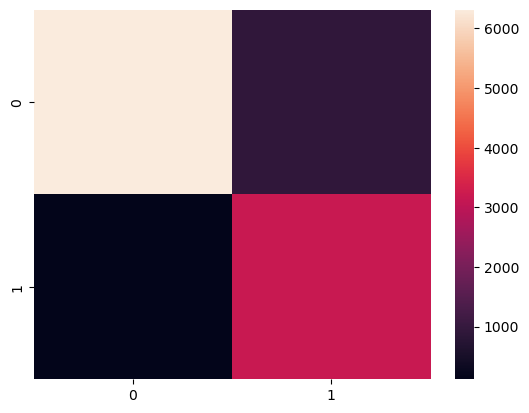

[[6315  903]
 [ 116 3177]]
roc_auc: 0.9198349278135768 Accuracy: 0.9030539434877747 f1: 0.8617930286179303 recall: 0.9647737625265715 precision: 0.7786764705882353


In [23]:
plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

0.7011216186496592

In [14]:
feature_importance = model.get_feature_importance()
feature_dic ={}
for feature, importance in zip(X_train.columns, feature_importance):
    feature_dic[feature] = importance
sorted_feature_dic = dict(sorted(feature_dic.items(), key=lambda x: x[1],reverse=True))
for key,value in sorted_feature_dic.items():
    print(key,value)

obv 1.770059083571845
ac_current_change4_1D_bin 1.030986482620854
volume_1D_bin 0.8667418759484282
ac_change3_1D_bin 0.5247839359548224
atr5_current_change9_1H_bin 0.5029547306530541
bwmfi_change7_1D_bin 0.4505812137559652
stdDev_1H_bin 0.4405376640975128
chaikin_current_change10_1D_bin 0.416113474105859
ad_1D_bin 0.39555860280934907
bwmfi_changeValue7_1D_bin 0.3762315961202057
atr5_current_change8_1H_bin 0.3759208106187725
atr10_current_change4_1H_bin 0.37404525969988894
slowk_changeValue7_1D_bin 0.35808820388061846
chaikin_change6_1D_bin 0.3515956419153964
ad_change8_1D_bin 0.34063039243299353
mfi_change2_1D_bin 0.3245087378726854
wpr_current_change1_1D_bin 0.31962509659032956
atr10_change9_1D_bin 0.31843311334383384
stdDev_changeValue10_1D_bin 0.318333253499939
bwmfi_changeValue2_1D_bin 0.31632639281774605
atr5_changeValue5_1D_bin 0.3038494815902066
rsi5_change5_1D_bin 0.3033825888239431
senkou_span_B_1D_bin 0.3019432740577962
atr10_current_change5_1H_bin 0.30135963074576555
triX_ch

# typeclass

In [ ]:
data = pd.read_csv("D:/propycharm2023/mq5/KDATA_type.csv")
data = data.drop(['Unnamed: 0', '时间','volume','订单规定价格', '订单ID', 'profit', '类型'], axis=1, inplace=False)
data = data.dropna(axis=0)
dorp_col = ['open_price','high_price','low_price','close_price','sma5','sma10','ema5','ema10',
            'smma5','smma10','lwma5','lwma10','sar','boll_upper_band','boll_middle_band','boll_lower_band',
            'ad','jaws','teeth','lips','ama','dema','envelopes_upper_value','envelopes_lower_value',
            'force','fractals_up_arrow','fractals_down_arrow','frAMA','tenkan_sen','kijun_sen','senkou_span_A',
            'senkou_span_B','chinkou_span','obv','tema','triX','vidya']

col = ['atr_5_10_type', 'macd_type', 'sma_5_10_type', 'ema_5_10_type', 'smma_5_10_type', 'lwma_5_10_type',
           'rsi_5_14_type', 'sar_type', 'adx_type', 'cci_type', 'stoch_type', 'boll_type', 'ac_type', 'ad_type',
           'adxWilder_type',
           'alligator_type', 'ama_type', 'ao_type', 'bearsPower_type', 'bullsPower_type', 'chaikin_type', 'dema_type',
           'deMarker_type', 'envelopes_type', 'force_type', 'fractals_type', 'frAMA_type', 'gator_type',
           'ichimoku_type',
           'bwmfi_type', 'momentum_type', 'mfi_type', 'osMA_type', 'obv_type', 'rvi_type', 'stdDev_type', 'tema_type',
           'triX_type', 'wpr_type', 'vidya_type',
           'ac_color', 'ao_color', 'gator_up_color', 'gator_downs_color', 'bwmfi_colors']
data = data.drop(dorp_col, axis=1, inplace=False)
X = data.drop(['type'], axis=1, inplace=False)
Y = data['type']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state = 3)
# 
train_pool = Pool(X_train[:-500],Y_train[:-500],cat_features = col)
eval_pool = Pool(X_train[-500:],Y_train[-500:],cat_features = col)
test_pool = Pool(X_test,cat_features = col)

params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'depth': 6,
    'loss_function':"Logloss",
    'od_type':"Iter",
    'class_weights':[1, 1.6]
    
}
model = CatBoostClassifier(**params)
model.fit(train_pool,eval_set=eval_pool)
#test
y_pred = model.predict(test_pool)


#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)

In [ ]:
plot=sns.heatmap(cmatrix)
plt.show()
print(cmatrix)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

In [15]:
# 创建数据集对象
# train_pool = Pool(X_train, Y_train)
#     'rsm':[0.8,0.9],
#     'fold_len_multiplier':[1.1,1.2,1.3]
# 定义参数网格 
params = {
    'iterations': [1000, 1500],
    'learning_rate': [0.02,0.03],
    'depth': [6, 8],
    'class_weights':[[1, 1.5],[1, 1.55],[1, 1.6],[1, 1.65]]
}

# 设置其他固定参数
fixed_params = {
    'loss_function':"Logloss",
    'od_type':"Iter",
}

# 执行网格搜索
model = CatBoostClassifier(**fixed_params)
grid_search   = GridSearchCV(model, param_grid = params, scoring="roc_auc", cv = 5)

grid_search .fit(X_train[:-10000],Y_train[:-10000],eval_set=(X_train[-10000:],Y_train[-10000:]))

# 输出最佳得分和最佳参数组合
print("Best Score:", grid_search.best_score_)
print("Best Params:", grid_search.best_params_)


ValueError: 
All the 160 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'A'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\conda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 2303, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 2184, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 1444, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 793, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 1425, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3956, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4006, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3822, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2788, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=6260]="A": Cannot convert 'b'A'' to float

--------------------------------------------------------------------------------
128 fits failed with the following error:
Traceback (most recent call last):
  File "_catboost.pyx", line 2288, in _catboost.get_float_feature
  File "_catboost.pyx", line 1141, in _catboost._FloatOrNan
  File "_catboost.pyx", line 951, in _catboost._FloatOrNanFromString
TypeError: Cannot convert 'b'B'' to float

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\conda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 5100, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 2303, in _fit
    train_params = self._prepare_train_params(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 2184, in _prepare_train_params
    train_pool = _build_train_pool(X, y, cat_features, text_features, embedding_features, pairs,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 1444, in _build_train_pool
    train_pool = Pool(X, y, cat_features=cat_features, text_features=text_features, embedding_features=embedding_features, pairs=pairs, weight=sample_weight, group_id=group_id,
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 793, in __init__
    self._init(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "D:\conda3\Lib\site-packages\catboost\core.py", line 1425, in _init
    self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,
  File "_catboost.pyx", line 3956, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 4006, in _catboost._PoolBase._init_pool
  File "_catboost.pyx", line 3822, in _catboost._PoolBase._init_features_order_layout_pool
  File "_catboost.pyx", line 2788, in _catboost._set_features_order_data_pd_data_frame
  File "_catboost.pyx", line 2329, in _catboost.create_num_factor_data
  File "_catboost.pyx", line 2290, in _catboost.get_float_feature
_catboost.CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=6260]="B": Cannot convert 'b'B'' to float


In [ ]:
# train_pool = Pool(X_train, Y_train)
params = {
    'iterations': 1000,
    'learning_rate': 0.02,
    'depth': 8,
    'early_stopping_rounds': 10,
    'loss_function':"Logloss",
    
}
# 'od_type':"Iter"
model = CatBoostClassifier(**params)
model.fit(X_train,Y_train)
#cat_features 具有分类特征的数据
# col=['grade','subGrade','employmentTitle','homeOwnership','verificationStatus']
# clf = model.fit(x_train,y_train, eval_set=(x_test,y_test),verbose=500,cat_features=col)
# prediction_type='Probability' 输出概率
# yy_pred_valid=clf.predict(x_test,prediction_type='Probability')


In [ ]:
# test_pool = Pool(X_test)
#test
y_pred = model.predict(X_test)
#混淆矩阵
cmatrix = confusion_matrix(Y_test, y_pred)
cmatrix[::-1, ::-1]

In [ ]:
#test
roc_auc = roc_auc_score(Y_test, y_pred)
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
print("roc_auc:",roc_auc,"Accuracy:", accuracy,"f1:", f1,"recall:", recall,"precision:", precision)

In [ ]:
##################
cv_params = {'iterations': [800,1000,1500],
            'learning_rate':[0.01, 0.02],
            'depth':[3,6],
            'rsm':[0.8,0.9],
            'fold_len_multiplier':[1.1]}
# other_params = {
#     'iterations': 1500,
#     'learning_rate':0.02,
#     'depth':3,
#     'rsm':0.8,
#     'fold_len_multiplier':1.1
# }
#指定category类型的列，可以是索引，也可以是列名
#分类特征，可以通过将其索引添加到cat_features参数中来指定它们
# cat_features = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
# optimized_cb.fit(X,Y,cat_features =category_features)
other_params = {}
model_cb = CatBoostClassifier(**other_params)
optimized_cb = GridSearchCV(estimator=model_cb, param_grid=cv_params, scoring='roc_auc', cv=5, verbose=1, n_jobs=2)
optimized_cb.fit(X_train[:-500],Y_train[:-500],eval_set=(X_train[-500:],Y_train[-500:]))
print('参数的最佳取值：{0}'.format(optimized_cb.best_params_))
print('最佳模型得分:{0}'.format(optimized_cb.best_score_))
# print(optimized_cb.cv_results_['mean_test_score'])
# print(optimized_cb.cv_results_['params'])

# KFold

In [ ]:
model=CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="AUC",
            learning_rate=0.02,
            iterations=1000,
            random_seed=2023,
            depth=8,
            rsm=0.9,
            fold_len_multiplier=1.1)

# 定义KFold交叉验证
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
answers = []
roc_auc_score_sum = 0
i = 0
for train, test in kfold.split(X_train, Y_train):  
    x_train = X_train.iloc[train]
    y_train = Y_train.iloc[train]
    x_test = X_train.iloc[test]
    y_test = Y_train.iloc[test]
#     print('x_train', x_train.shape)
#     print('y_train', y_train.shape)
    clf = model.fit(x_train,y_train, eval_set=(x_test,y_test),verbose=500)
    
#     yy_pred_valid=clf.predict(x_test,prediction_type='Probability')[:,-1]
    yy_pred_valid=clf.predict(x_test)
    answers.append(yy_pred_valid)
#     print(yy_pred_valid)
    roc_auc_score_ = roc_auc_score(y_test, yy_pred_valid)
    roc_auc_score_sum += roc_auc_score_
    print('roc_auc_score:{}'.format(roc_auc_score_))
    print('f1_score:{}'.format(f1_score(y_test, yy_pred_valid)))
    print('accuracy_score:{}'.format(accuracy_score(y_test, yy_pred_valid)))
    print('recall_score:{}'.format(recall_score(y_test, yy_pred_valid)))
    i = i + 1
    
print('\nmean roc_auc:{}'.format(roc_auc_score_sum/i))